In [1]:
import pandas as pd
import numpy as np
import io
import os
from openTSNE import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

In [2]:
PATH = 's3://p9-data-benoit-pr/data'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        s3://p9-data-benoit-pr/data
PATH_Data:   s3://p9-data-benoit-pr/data/Test
PATH_Result: s3://p9-data-benoit-pr/data/Results


In [3]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')
df['label'] = df['path'].str.extract(r'Test/([^/]+)/')
df = df.drop(columns=['path'])
display(df.head(5))

,label,features
0,Watermelon,"[0.00501114, 0.29237127, 0.0, 0.03768493, 1.16..."
1,Watermelon,"[0.02950827, 0.068163045, 0.0, 0.016227275, 0...."
2,Pineapple Mini,"[0.0, 4.9297247, 0.0, 0.0, 0.0, 0.0, 0.1340699..."
3,Watermelon,"[0.9807948, 0.1833398, 0.0036116035, 0.0577274..."
4,Pineapple Mini,"[0.016547602, 4.5139093, 0.0, 0.0, 0.0, 0.0, 0..."


In [4]:
print(df.shape)

(22688, 2)


In [5]:
features = np.array(df['features'].tolist())
labels = df['label'].values

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [6]:
tsne = TSNE(n_components=2, verbose=True, n_jobs=-1, random_state=42)
tsne_results = tsne.fit(features)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 18.74 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.61 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.85 seconds
===> Running optimization with exaggeration=12.00, lr=1890.67 for 250 iterations...
Iteration   50, KL divergence 3.9902, 50 iterations in 1.5246 sec
Iteration  100, KL divergence 3.3931, 50 iterations in 1.4927 sec
Iteration  150, KL divergence 3.0007, 50 iterations in 1.4360 sec
Iteration  200, KL divergence 2.7688, 50 iterations in 1.5174 sec
Iteration  250, KL divergence 2.6124, 50 iterations in 1.4355 sec
   --> Time elapsed: 7.41 seconds
===> Running optimization with exaggeration

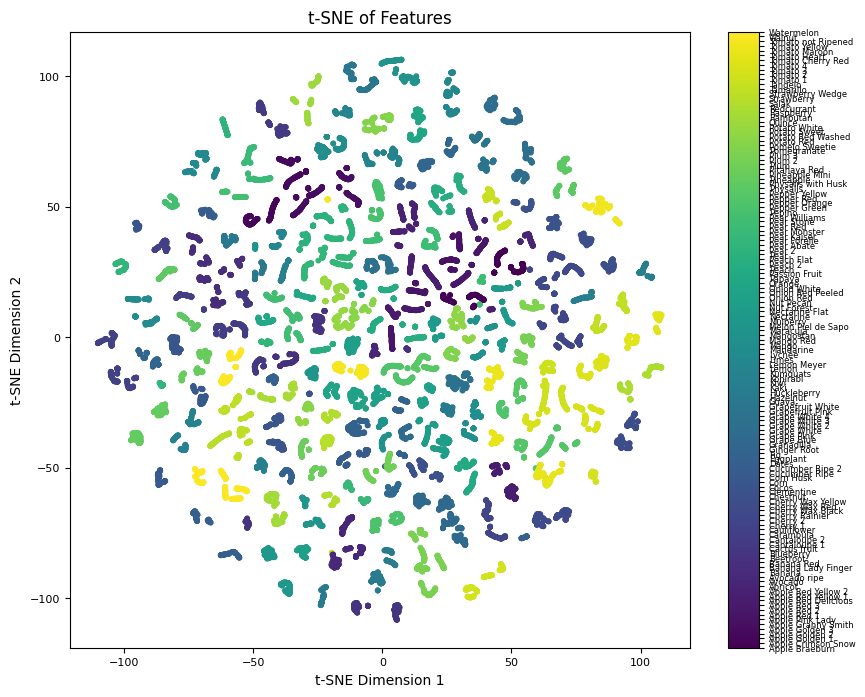

In [7]:
plt.figure(figsize=(10, 8))

# Adjust the 's' parameter to make the dots smaller
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=numeric_labels, cmap='viridis', s=10)

# Customize colorbar with smaller ticks
cbar = plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)), format=plt.FuncFormatter(lambda i, _: label_encoder.classes_[i]))
cbar.ax.tick_params(labelsize=6)  # Make colorbar ticks smaller

# Customize x and y ticks
plt.tick_params(axis='both', which='major', labelsize=8)

plt.title('t-SNE of Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [8]:
unique_labels = df['label'].unique()

# on sépare les labels en deux
half_point = len(unique_labels) // 2
labels1 = unique_labels[:half_point]
labels2 = unique_labels[half_point:]

# on sépare en deux dataframes
df1 = df[df['label'].isin(labels1)]
df2 = df[df['label'].isin(labels2)]

df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

In [9]:
# extraction des features

# features de df1
features_tsne_1 = np.array(df1['features'].tolist())
labels_tsne_1 = df1['label'].values

label_encoder_1 = LabelEncoder()
numeric_labels_1 = label_encoder_1.fit_transform(labels_tsne_1)

# features de df2
features_tsne_2 = np.array(df2['features'].tolist())
labels_tsne_2 = df2['label'].values

label_encoder_2 = LabelEncoder()
numeric_labels_2 = label_encoder_2.fit_transform(labels_tsne_2)

In [10]:
#calcul des TSNE
tsne_results_1 = tsne.fit(features_tsne_1)
tsne_results_2 = tsne.fit(features_tsne_2)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 9.29 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.31 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.43 seconds
===> Running optimization with exaggeration=12.00, lr=929.42 for 250 iterations...
Iteration   50, KL divergence 3.3490, 50 iterations in 1.2591 sec
Iteration  100, KL divergence 2.8116, 50 iterations in 1.2771 sec
Iteration  150, KL divergence 2.4713, 50 iterations in 1.3062 sec
Iteration  200, KL divergence 2.2831, 50 iterations in 1.1657 sec
Iteration  250, KL divergence 2.1610, 50 iterations in 1.2028 sec
   --> Time elapsed: 6.21 seconds
===> Running optimization with exaggeration=1

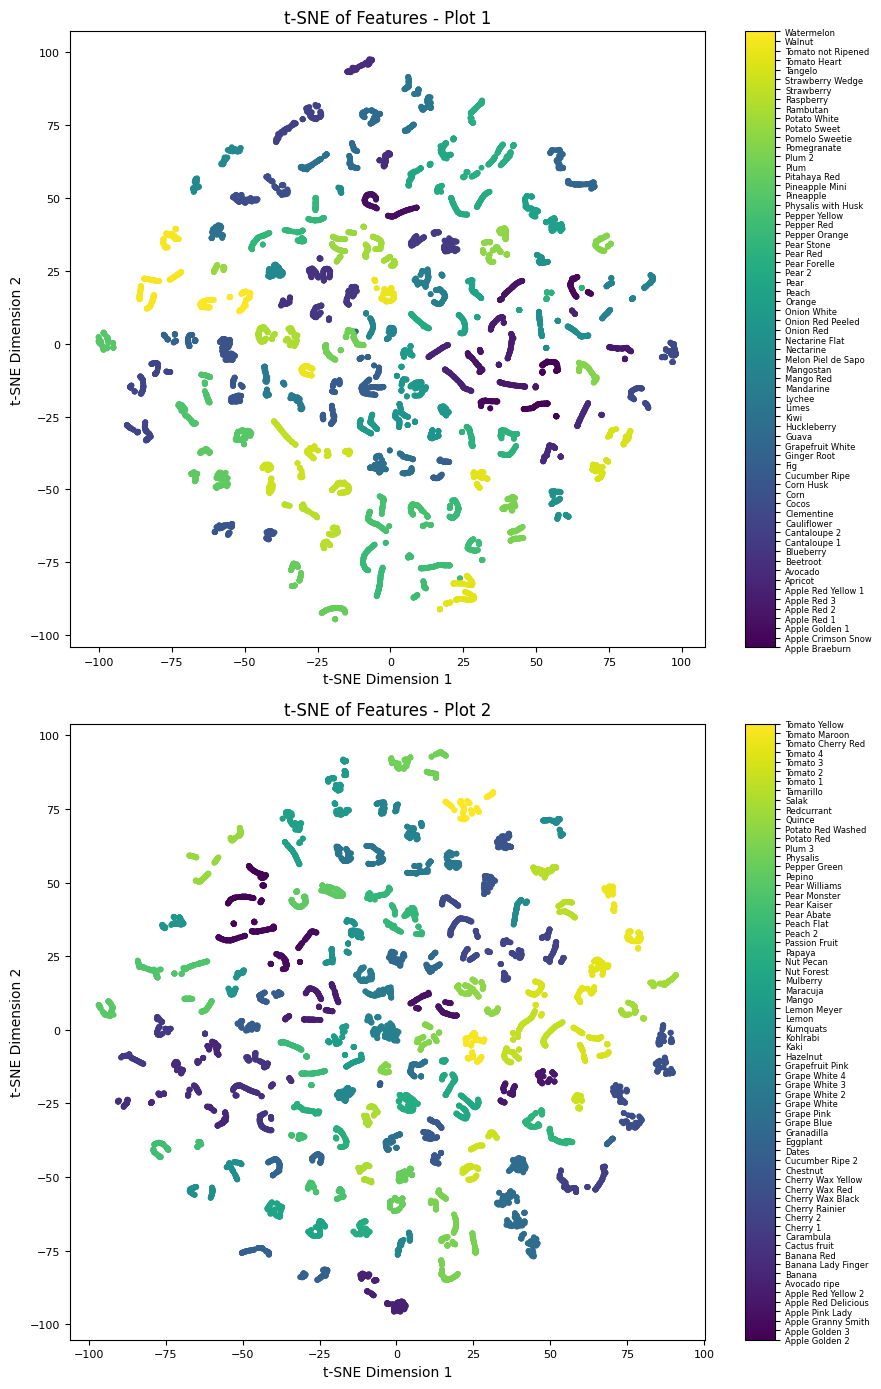

In [11]:
plt.figure(figsize=(9, 14))

# Plot 1
plt.subplot(2, 1, 1)  
scatter1 = plt.scatter(tsne_results_1[:, 0], tsne_results_1[:, 1], c=numeric_labels_1, cmap='viridis', s=10)
cbar1 = plt.colorbar(scatter1, ticks=range(len(label_encoder_1.classes_)), format=plt.FuncFormatter(lambda i, _: label_encoder_1.classes_[i]))
cbar1.ax.tick_params(labelsize=6)  
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('t-SNE of Features - Plot 1')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Plot 2
plt.subplot(2, 1, 2)  
scatter2 = plt.scatter(tsne_results_2[:, 0], tsne_results_2[:, 1], c=numeric_labels_2, cmap='viridis', s=10)
cbar2 = plt.colorbar(scatter2, ticks=range(len(label_encoder_2.classes_)), format=plt.FuncFormatter(lambda i, _: label_encoder_2.classes_[i]))
cbar2.ax.tick_params(labelsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title('t-SNE of Features - Plot 2')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Layout
plt.tight_layout()
plt.show()
